In [1]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np 
import statsmodels.api as sm
import polars_ols as pls
from finance_byu import fama_macbeth

# Loading Data

In [2]:
bond_data = pl.read_parquet('../../data/final_data/bond_data_insample.pq')
print(bond_data.head())

shape: (5, 99)
┌─────┬────────────┬───────────┬────────────┬───┬──────────┬─────────────┬──────────────┬──────────┐
│     ┆ date       ┆ cusip     ┆ exretn_t+1 ┆ … ┆ datadate ┆ shortintadj ┆ unexpected_i ┆ oas      │
│ --- ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---      ┆ ---         ┆ nflation     ┆ ---      │
│ i64 ┆ date       ┆ str       ┆ f64        ┆   ┆ date     ┆ f64         ┆ ---          ┆ f64      │
│     ┆            ┆           ┆            ┆   ┆          ┆             ┆ f64          ┆          │
╞═════╪════════════╪═══════════╪════════════╪═══╪══════════╪═════════════╪══════════════╪══════════╡
│ 7   ┆ 2002-08-31 ┆ 00077QAG5 ┆ 0.02983    ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.013937 │
│ 11  ┆ 2002-08-31 ┆ 00104CAA6 ┆ -0.023513  ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.184844 │
│ 12  ┆ 2002-08-31 ┆ 001055AB8 ┆ 0.004369   ┆ … ┆ null     ┆ null        ┆ 0.004985     ┆ 0.016772 │
│ 20  ┆ 2002-08-31 ┆ 00130HAQ8 ┆ -0.080008  ┆ … ┆ null     ┆ null        ┆ 0

# Segmenting in Buckets, based on Rating, Industry, Duration

## Rating

Group by rating macro-categories

In [3]:
bond_data_with_ratings = bond_data.with_columns(
    rating_bucket=pl
        .when(pl.col('rating') <= 7).then(pl.lit('A'))
        .when(pl.col('rating') <= 16).then(pl.lit('B'))
        .otherwise(pl.lit('B'))
)
bond_data = bond_data_with_ratings

## Industry

We choose the following macro-groups, based on the first digit of the SIC Code: 

- 0, 1: Agriculture, Forestry, Fishing (0) + Mining (1) + Construction (1)
- 2, 3, 5: Manufacturing (2,3), Whole Sale Trade + Retail Trade (5)
- 4, 9: Transportation and Public Utilities (4), Public Administration (9)
- 6: Finance, Insurance, Real Estate (6)
- 7, 8: Service (7, 8)


In [4]:
bond_data.select('PERMNO', 'sic_code').head(4)

PERMNO,sic_code
i64,i64
84766,6029
null,4911
57904,6321
76712,4911


In [5]:
bond_data = bond_data.with_columns(
    industry_bucket=pl.col('sic_code').cast(str).str.slice(0,1).cast(int)
).with_columns(
    # assign bucket from 1 to 5 for the corresponding macro-group
    industry_bucket=pl
        .when(pl.col('industry_bucket').is_in([0,1])).then(pl.lit(1))
        .when(pl.col('industry_bucket').is_in([2,3,5])).then(pl.lit(2))
        .when(pl.col('industry_bucket').is_in([4,9])).then(pl.lit(3))
        .when(pl.col('industry_bucket') == 6).then(pl.lit(4))
        .when(pl.col('industry_bucket').is_in([7,8])).then(pl.lit(5))
)

bond_data.select('industry_bucket').head(3)

industry_bucket
i32
4
3
4


In [6]:
bond_data.select('industry_bucket').unique()

industry_bucket
i32
3
4
1
5
2


## Duration 

In [7]:
bond_data.select('duration').quantile(1/3)

duration
f64
4.187136


In [8]:
bond_data.select('duration').quantile(2/3)

duration
f64
7.036823


In [9]:
bond_data = bond_data.with_columns(
    duration_bucket=pl
        .when(pl.col('duration') <= 4).then(pl.lit(1))
        .when(pl.col('duration') <= 7).then(pl.lit(2))
        .otherwise(pl.lit(3))
)


## Aggregate the buckets in one column

In [10]:
bond_data = bond_data.with_columns(
    bucket=(pl.col('industry_bucket').cast(str) + '_' + pl.col('rating_bucket') + '_' + pl.col('duration_bucket').cast(str))
).drop(['industry_bucket', 'rating_bucket', 'duration_bucket'])

In [11]:
bond_data.select('bucket').head(3)

bucket
str
"""4_A_2"""
"""3_B_2"""
"""4_A_2"""


In [12]:
bonds_per_date_bucket = bond_data.group_by(['date', 'bucket']).n_unique().select('date', 'bucket', 'cusip')

bonds_per_date_bucket.head()

date,bucket,cusip
date,str,u32
2014-03-31,"""4_A_1""",228
2004-05-31,"""4_B_3""",56
2004-11-30,"""2_B_1""",124
2003-06-30,"""5_B_2""",63
2008-09-30,"""3_A_3""",140


In [13]:
bonds_per_date_bucket.filter(pl.col('cusip') < 10).shape[0] / bonds_per_date_bucket.shape[0]

0.08677034032003605

# Compute Residual Returns

In [14]:
def weighted_median_pl(data: pl.type_aliases.Sequence[pl.Series]):
    """Compute weighted median of observations with Polars

    To be used inside map_groups, to which you specify as expressions first the values, then the weights to use.
    The function takes two pl.Series: the first is the values to use, the second is the weights. 
    The function returns the weighted median for the given group of observations
    """
    values, weights = data
    values = values.to_numpy()
    weights = weights.to_numpy()
    i = np.argsort(values) 
    c = np.cumsum(weights[i])

    weighted_median = values[i[np.searchsorted(c, 0.5 * c[-1])]]
    return weighted_median


In [15]:
def compute_residual_returns(df: pl.DataFrame, use_median: bool = False):
    """Compute Residual return as unadjusted return - systematic return.
    
    * dxs = Duration * Spread
    * Systematic Return = Relative DTS * Weighted average return of bond's bucket
    * Relative dxs = Bond DTS / weighted average DTS of bond bucket
    
    * Residual return = bond_ret_t+1 - Systmematic Return
    
    """
    df = df.with_columns(
        dxs = pl.col('duration') * pl.col('oas')
    )
    
    grouped = df.select('bucket', 'dxs', 'exretnc_dur_t+1', 'bond_amount_out').drop_nulls().group_by('bucket')
    
    if use_median: 
        weighted_dxs = grouped.agg(
            weighted_dxs_median=pl.map_groups(exprs=['dxs', 'bond_amount_out'], function=weighted_median_pl),
            weighted_ret_median=pl.map_groups(exprs=['exretnc_dur_t+1', 'bond_amount_out'], function=weighted_median_pl)
        )
    else: 
        weighted_dxs = grouped.agg(
            weighted_dxs_mean=(pl.col('dxs').dot(pl.col('bond_amount_out')) / pl.sum('bond_amount_out')),
            weighted_ret_mean=(pl.col('exretnc_dur_t+1').dot(pl.col('bond_amount_out')) / pl.sum('bond_amount_out')),
        )
        
    dxs_col = 'weighted_dxs_' + ('median' if use_median else 'mean')
    ret_col = 'weighted_ret_' + ('median' if use_median else 'mean')
    
    df = (df.select(pl.all().exclude(dxs_col, ret_col))
        .join(weighted_dxs, how='left', on='bucket')
        .with_columns(
            relative_dxs = pl.col('dxs') / pl.col(dxs_col)
        ).with_columns(
            systematic_return = pl.col('relative_dxs') * pl.col(ret_col)
        ).with_columns(
            (pl.col('bond_ret_t+1') - pl.col('systematic_return')).alias('residual_return_t+1'),
        ))
    
    return df

In [16]:
bond_data = compute_residual_returns(bond_data, use_median=True)

# Scoring Signals based on the quantile 

## Shared Functions

In [17]:
def compute_quantiles(df: pl.DataFrame, col: str, n_quantiles: int):
    """Divide the cols in quantiles based on the bucket groups"""
    quantile_col_name = f'{col}_quantile'
    delta_col_name = f'{col}_bucket_delta'
    mean_col_name = f'{col}_bucket_mean'
    
    # create the bins and labels to be used in qcut
    bins = np.linspace(0,1,n_quantiles+1)[1:]
    labels = [str(i+1) for i in range(n_quantiles+1)]
    
    # compute the mean of the signal for each bucket at each date
    col_mean_by_bucket = df.select('date', 'bucket', col).group_by(['date', 'bucket']).agg(
        pl.col(col).drop_nans().mean().alias(mean_col_name) # .mean breaks with NaNs, so drop them 
    )
    
    # join the dataframes and compute the difference with respect to the group average (computed before)
    deltas = (df
              .select(pl.all().exclude(quantile_col_name, mean_col_name))
              .join(col_mean_by_bucket, how='left', on=['date', 'bucket'])
              .with_columns(
                    (pl.col(col) - pl.col(mean_col_name)).alias(delta_col_name)
                )           
              )
    # just select the cols we need, to make computations faster
    deltas = deltas.select('date', 'cusip', 'bucket', delta_col_name)

    data = []
    total_items = col_mean_by_bucket.shape[0]
    print('computing... ', end='')

    i = 0
    for group in col_mean_by_bucket.iter_rows(named=True):
        i += 1
        
        # filter for NaNs and Nulls as well 
        mask = (pl.col('date') == group['date']) & (pl.col('bucket') == group['bucket']) & (pl.col(delta_col_name).is_not_nan() & (pl.col(delta_col_name).is_not_null()))
        
        group_data = deltas.filter(mask)
        # if the DataFrame is emtpy just continue, otherwise qcut will throw an error
        if group_data.shape[0] == 0:
            continue
        
        group_data = group_data.with_columns(
            pl.col(delta_col_name).qcut(bins,labels=labels, allow_duplicates=True).alias(quantile_col_name)
        )
            
        data.append(group_data)
        
        if i % 1000 == 0: 
            print(f'{i}/{total_items} ', end='')
    
    print('... done!')
    
    quantiles = pl.concat(data, how='vertical')
    quantiles = quantiles.with_columns(
        pl.col(quantile_col_name).cast(int).alias(quantile_col_name)
    )
    return df.join(quantiles.drop('bucket'), how='left', on=['date', 'cusip'])

In [18]:
# # DEPRECATED, USE get_expected_alpha
# def get_quantile_portfolios_returns(
#         df_with_quantiles: pl.DataFrame, 
#         quantile_col: str, 
#         return_col: str = 'exretnc_dur_t+1', 
#         plot: bool = False,
#         interpolate: bool = False,
# ): 
#     # group returns by date and the quantile, and compute the average return of the portfolio at the end of every month
#     returns_by_date_bucket = df_with_quantiles.group_by(['date', quantile_col]).agg(
#         pl.col(return_col).drop_nans().mean().alias('mean_return'), # mean return of the portfolio at EoM
#     )
#     
#     returns_by_date_bucket = returns_by_date_bucket.filter(pl.col(quantile_col).is_not_null())
#     
#     # down sample returns to yearly, and compute the total return of the portfolios at the end of every year
#     yearly_returns_by_date_bucket = returns_by_date_bucket.sort('date').group_by_dynamic('date', every='1y', group_by=quantile_col).agg(
#         pl.col('mean_return').add(1).product(), # compute the total return over the year
#         (pl.col('mean_return').std() * np.sqrt(12)).alias('yearly_stdev') # compute the standard deviation of the returns
#     )
#     
#     # finally, group by the quantile column and compute the average yearly return
#     avg_yearly_returns_by_bucket = yearly_returns_by_date_bucket.group_by(quantile_col).agg(
#         pl.col('mean_return').mean().sub(1), # compute the mean return and subtract 1
#         pl.col('yearly_stdev').mean(), # compute average of the standard deviation of the portfolio
#         (pl.col('mean_return').sub(1) / pl.col('yearly_stdev')).mean().alias('sharpe_ratio')
#     )
#     
#     # insert the key to sort by
#     avg_yearly_returns_by_bucket = avg_yearly_returns_by_bucket.sort(by=quantile_col)
#     
#     spline = None
#     if interpolate: 
#         data = avg_yearly_returns_by_bucket.select(quantile_col, 'mean_return').to_numpy()
#         x, y = data[:, 0], data[:, 1]
#         
#         spline = UnivariateSpline(x,y,s=len(x), k=3, ext=3)
#         
#     if plot: 
#         fig, ax = plt.subplots()
#         
#         alpha = 0.3 if interpolate else 1
#         ax.bar(x=avg_yearly_returns_by_bucket[quantile_col], height=avg_yearly_returns_by_bucket['mean_return'], alpha=alpha)
#         ax.scatter(x=avg_yearly_returns_by_bucket[quantile_col], y=avg_yearly_returns_by_bucket['yearly_stdev'], label='Volatility')
#         ax2 = ax.twinx()
#         ax2.scatter(x=avg_yearly_returns_by_bucket[quantile_col], y=avg_yearly_returns_by_bucket['sharpe_ratio'], label='Sharpe Ratio')
#         ax.legend()
#         
#         if interpolate: 
#             x_new = np.linspace(x[0], x[-1], 100)
#             ax.plot(x_new, spline(x_new))
#     
#     return avg_yearly_returns_by_bucket

In [69]:
from skmisc.loess import loess

def get_expected_alpha(
        df_with_quantiles: pl.DataFrame, 
        quantile_col: str,  
        plot: bool = False,
        interpolate: bool = False,
): 
    return_col = 'residual_return_t+1'
    
    # group returns by date and the quantile, and compute the average return of the portfolio at the end of every month
    monthly_returns_by_bucket = df_with_quantiles.group_by(['date', quantile_col]).agg(
        pl.col(return_col).drop_nans().mean().alias('mean_return'), # mean return of the portfolio at EoM
    )
    
    final_portfolio_returns = monthly_returns_by_bucket.group_by(quantile_col).agg(
        pl.col('mean_return').mean().alias('avg_monthly_return'),
        pl.col('mean_return').std().alias('monthly_stdev'),
        ((pl.col('mean_return').mean() / pl.col('mean_return').std()) * np.sqrt(12)).alias('sharpe_ratio'),
    )
    
    # insert the key to sort by
    final_portfolio_returns = final_portfolio_returns.sort(by=quantile_col).drop_nulls()
    
    spline_loess = None
    if plot: 
        fig, axs = plt.subplots(1,2, figsize=(12,6))
        
        ax1, ax2 = axs
        
        alpha = 0.3 if interpolate else 1
        ax1.bar(x=final_portfolio_returns[quantile_col], height=final_portfolio_returns['avg_monthly_return'])
        ax12 = ax1.twinx()
        ax12.scatter(x=final_portfolio_returns[quantile_col], y=final_portfolio_returns['monthly_stdev'], label='Volatility')
        # ax12.scatter(x=final_portfolio_returns[quantile_col], y=final_portfolio_returns['sharpe_ratio'], label='Sharpe Ratio')
        ax1.legend()
        
        ax2.axhline(color='black')
     
        data = final_portfolio_returns.select(quantile_col, 'avg_monthly_return').to_numpy()
        x, y = data[:, 0], data[:, 1]
        
        spline_loess = loess(x,y)
        spline_loess.fit()
        
        x_new = np.linspace(x[0], x[-1], 100)
        pred = spline_loess.predict(x_new, stderror=True)
        conf = pred.confidence()
        
        lowess_vals = pred.values
        ll = conf.lower
        ul = conf.upper
        
        x_new = np.linspace(x[0], x[-1], 100)
    
        ax2.fill_between(x_new,ll,ul,alpha=0.5)
        ax2.scatter(x=final_portfolio_returns[quantile_col], y=final_portfolio_returns['avg_monthly_return'], label='Expected Alpha')
        ax2.plot(x_new, lowess_vals)

    return final_portfolio_returns, spline_loess

In [20]:
def _update_transition_prob_matrix(chain, counts_matrix, lag):
    flat_coords = np.ravel_multi_index((chain[:-lag], chain[lag:]), counts_matrix.shape)
    return np.bincount(flat_coords, minlength=counts_matrix.size).reshape(counts_matrix.shape)

def _convert_to_probabilities(transition_matrix: np.ndarray): 
    M = transition_matrix.copy()
    for row in M: 
        n = sum(row)
        if n > 0: 
            row[:] = [f/n for f in row] 
    
    return M

def compute_transition_matrix(df_with_quantiles: pl.DataFrame, quantile_col: str, n_quantiles: int, lag: int = 1, plot: bool = False):
    """Compute the transition probabilities for quantiles for a given signal, given a certain lag (1 unit of lag is 1 month of time)"""
    
    # group by the cusip, and get the evolution of the quantile during time for each bond
    quantiles_evolution = df_with_quantiles.sort('date').filter(pl.col(quantile_col).is_not_null()).group_by('cusip', maintain_order=True).agg(pl.col(quantile_col))
    
    # initialize the matrix of transition probabilities
    transition_probabilities = np.zeros((n_quantiles, n_quantiles), dtype=np.float64)
    
    # iterate through the different evolutions and update the transition probabilities
    for row in quantiles_evolution.iter_rows(): 
        chain = row[1]
        if np.min(chain) != 0: 
            chain -= np.min(chain)
        
        transition_probabilities[:, :] += _update_transition_prob_matrix(chain, transition_probabilities, lag)
    
    # convert these to actual probabilities
    transition_probabilities = _convert_to_probabilities(transition_probabilities)
    
    if plot: 
        fig, ax = plt.subplots()
        ax.imshow(transition_probabilities, cmap='hot', interpolation='nearest')
    
    return transition_probabilities

## Carry

For carry, we rank each bond based on its OAS. 

In [21]:
oas_quantiles = compute_quantiles(bond_data, 'oas', 10) 

computing... 1000/4437 2000/4437 3000/4437 4000/4437 ... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


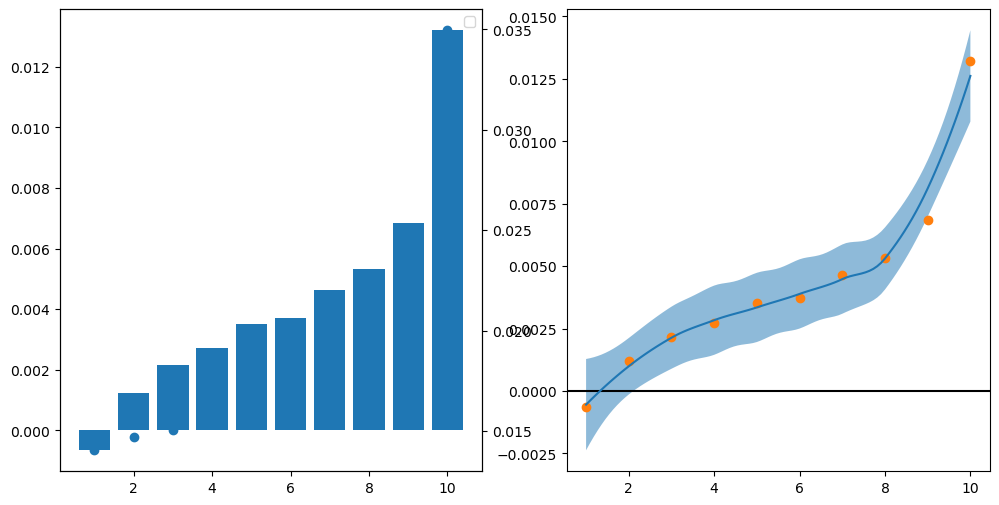

In [70]:
carry_returns, oas_spline = get_expected_alpha(oas_quantiles, 'oas_quantile', plot=True, interpolate=True)

In [58]:
carry_returns.with_columns(
    ((pl.col('avg_monthly_return') - pl.col('avg_monthly_return').mean()) / pl.col('avg_monthly_return').std()).alias('expected_alpha_z')
)

oas_quantile,avg_monthly_return,monthly_stdev,sharpe_ratio,expected_alpha_z
i64,f64,f64,f64,f64
1,-0.000656,0.014037,-0.161928,-1.300484
2,0.001219,0.014676,0.287683,-0.805168
3,0.00216,0.015052,0.497079,-0.55657
4,0.002723,0.015797,0.597041,-0.407894
5,0.003517,0.01588,0.7672,-0.19808
6,0.003704,0.016759,0.765702,-0.148589
7,0.004641,0.018159,0.885328,0.09885
8,0.005322,0.020012,0.921306,0.278857
9,0.006832,0.023859,0.991946,0.67768


In [56]:
oas_spline.predict([3]).values

array([0.00213318])

In [23]:
oas_quantiles.select('date', 'cusip', 'residual_return_t+1', 'oas_quantile').max()

date,cusip,residual_return_t+1,oas_quantile
date,str,f64,i64
2014-12-31,"""989822AA9""",4.069913,10


In [24]:
oas_quantiles.select('date', 'cusip', 'residual_return_t+1', 'oas_quantile').max()

date,cusip,residual_return_t+1,oas_quantile
date,str,f64,i64
2014-12-31,"""989822AA9""",4.069913,10


<Axes: xlabel='oas_bucket_delta', ylabel='residual_return_t+1'>

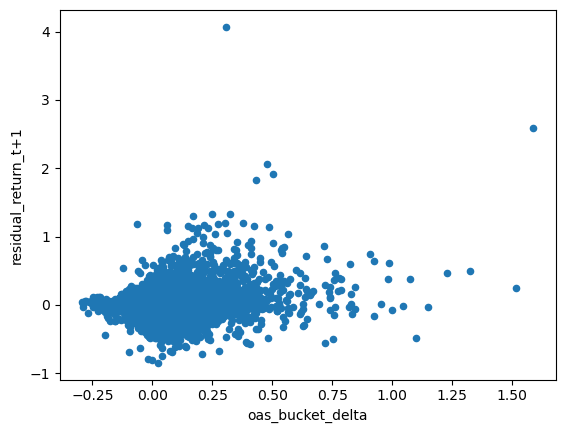

In [50]:
oas_quantiles.select('date', 'cusip', 'residual_return_t+1', 'oas_bucket_delta').to_pandas().plot(kind='scatter', x='oas_bucket_delta', y='residual_return_t+1')

array([[62., 23.,  7.,  3.,  2.,  1.,  1.,  1.,  0.,  0.],
       [19., 50., 20.,  6.,  2.,  1.,  1.,  0.,  0.,  0.],
       [ 6., 21., 44., 18.,  6.,  2.,  1.,  1.,  0.,  0.],
       [ 3.,  7., 21., 41., 17.,  5.,  2.,  1.,  1.,  0.],
       [ 2.,  3.,  8., 22., 40., 16.,  5.,  2.,  1.,  1.],
       [ 1.,  2.,  4.,  8., 21., 39., 16.,  5.,  2.,  1.],
       [ 1.,  2.,  3.,  5.,  9., 21., 39., 15.,  5.,  2.],
       [ 1.,  1.,  2.,  3.,  5.,  9., 20., 40., 14.,  4.],
       [ 2.,  1.,  2.,  2.,  3.,  5.,  8., 20., 44., 13.],
       [ 2.,  2.,  2.,  2.,  3.,  3.,  5.,  8., 19., 54.]])

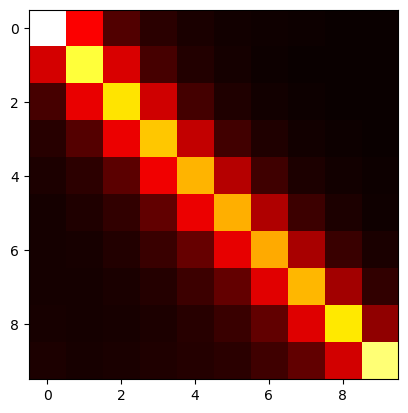

In [26]:
transition_probs = compute_transition_matrix(oas_quantiles, 'oas_quantile', 10, lag=1, plot=True)
np.round(transition_probs, 2) * 100

## Momentum (Excess Credit Return)

We use the **Credit Excess Return**, as defined by the AQR paper, to define momentum.

$$
CER_t=\frac{1}{12}Spread_{t-1}-\text{Spread Duration}_{t-1}\times(Spread_t-Spread_{t-1})
$$

Which translated to our data is

$$
CER_t=\frac{1}{12}OAS_{t-1}-\text{duration}_{t-1}\times(OAS_t-OAS_{t-1})
$$


In [27]:
bond_data.select('YIELD', 'bond_yield').null_count()

YIELD,bond_yield
u32,u32
2654,2654


In [28]:
# compute excess credit return at each timestamp
bond_data = bond_data.sort(['cusip', 'date'])
bond_data = bond_data.with_columns(
    spread_duration = pl.col('oas') / pl.col('bond_yield') * pl.col('duration') / pl.col('bond_yield').add(1)
).with_columns(
    excess_credit_ret=(pl.col('oas').shift(1) / 12 - pl.col('spread_duration') * (pl.col('oas') - pl.col('oas').shift(1)))
)

mask = pl.col('cusip') != pl.col('cusip').shift(1)

bond_data = bond_data.with_columns(
    excess_credit_ret=pl.when(mask).then(np.nan).otherwise(pl.col('excess_credit_ret'))
)

In [29]:
# compute the x_month rolling excess return
def momentum(df: pl.DataFrame, period: str, min_periods: int, n_months: int):
    momentum_returns = df.sort(['cusip', 'date']).rolling('date', group_by='cusip', period=period).agg(
        pl.when(pl.col('excess_credit_ret').len() > min_periods).then(pl.col('excess_credit_ret').add(1).product().sub(1)).otherwise(np.nan).alias(f'mom_{n_months}mo'),
        pl.when(pl.col('excess_credit_ret').len() > min_periods).then(pl.col('bondprc').last() / pl.col('bondprc').first() - 1).otherwise(np.nan).alias(f'price_mom_{n_months}mo'),
    )
    return momentum_returns


mom_6mo = momentum(bond_data, '5mo20d', 5, 6)
mom_12mo = momentum(bond_data, '11mo20d', 9, 12)

bond_data = bond_data.join(
    mom_6mo,
    how='left',
    on=['cusip', 'date'],
).join(
    mom_12mo,
    how='left',
    on=['cusip', 'date'],
)

In [30]:
mom_quantiles_6mo = compute_quantiles(bond_data, 'price_mom_6mo', 10)
mom_quantiles_12mo = compute_quantiles(bond_data, 'price_mom_12mo', 10)

computing... 1000/4437 2000/4437 3000/4437 4000/4437 ... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


computing... 1000/4437 2000/4437 3000/4437 4000/4437 ... done!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(shape: (10, 4)
 ┌────────────────────────┬────────────────────┬───────────────┬──────────────┐
 │ price_mom_6mo_quantile ┆ avg_monthly_return ┆ monthly_stdev ┆ sharpe_ratio │
 │ ---                    ┆ ---                ┆ ---           ┆ ---          │
 │ i64                    ┆ f64                ┆ f64           ┆ f64          │
 ╞════════════════════════╪════════════════════╪═══════════════╪══════════════╡
 │ 1                      ┆ 0.012411           ┆ 0.03069       ┆ 1.400894     │
 │ 2                      ┆ 0.006596           ┆ 0.020526      ┆ 1.113124     │
 │ 3                      ┆ 0.005063           ┆ 0.018006      ┆ 0.974036     │
 │ 4                      ┆ 0.004131           ┆ 0.016893      ┆ 0.847085     │
 │ 5                      ┆ 0.003452           ┆ 0.015323      ┆ 0.780392     │
 │ 6                      ┆ 0.003133           ┆ 0.015538      ┆ 0.698579     │
 │ 7                      ┆ 0.002439           ┆ 0.015074      ┆ 0.560505     │
 │ 8                    

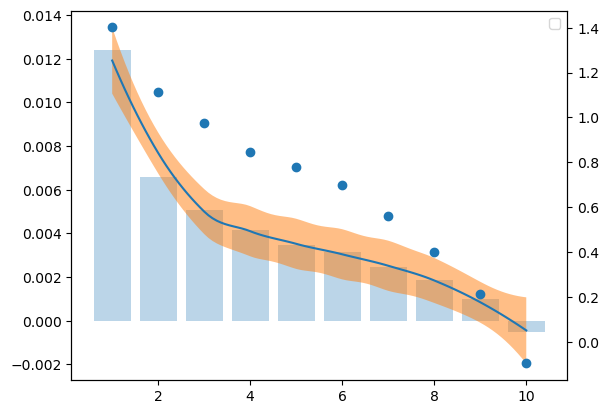

In [31]:
get_expected_alpha(mom_quantiles_6mo, 'price_mom_6mo_quantile', plot=True, interpolate=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(shape: (10, 4)
 ┌─────────────────────────┬────────────────────┬───────────────┬──────────────┐
 │ price_mom_12mo_quantile ┆ avg_monthly_return ┆ monthly_stdev ┆ sharpe_ratio │
 │ ---                     ┆ ---                ┆ ---           ┆ ---          │
 │ i64                     ┆ f64                ┆ f64           ┆ f64          │
 ╞═════════════════════════╪════════════════════╪═══════════════╪══════════════╡
 │ 1                       ┆ 0.011585           ┆ 0.035046      ┆ 1.145126     │
 │ 2                       ┆ 0.006138           ┆ 0.023924      ┆ 0.888809     │
 │ 3                       ┆ 0.004739           ┆ 0.019302      ┆ 0.850514     │
 │ 4                       ┆ 0.003789           ┆ 0.016715      ┆ 0.785192     │
 │ 5                       ┆ 0.002834           ┆ 0.016393      ┆ 0.598847     │
 │ 6                       ┆ 0.002205           ┆ 0.015582      ┆ 0.490137     │
 │ 7                       ┆ 0.001904           ┆ 0.014966      ┆ 0.440743     │
 │ 8        

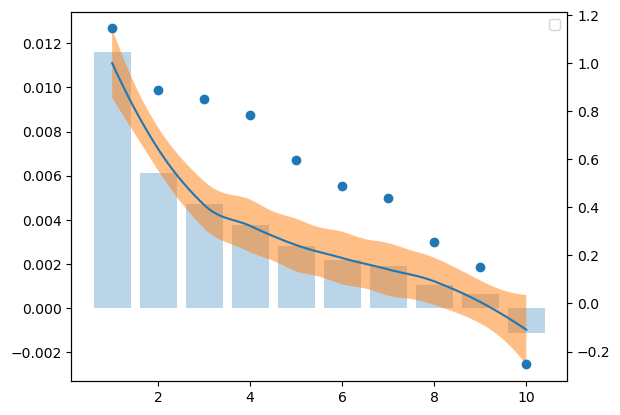

In [32]:
get_expected_alpha(mom_quantiles_12mo, 'price_mom_12mo_quantile', plot=True, interpolate=True)

array([[0.38265221, 0.18300654, 0.10840576, 0.07962843, 0.05765041,
        0.04577558, 0.03816227, 0.03442745, 0.03119538, 0.03909598],
       [0.20198177, 0.21831153, 0.16229357, 0.11465187, 0.08450258,
        0.06296737, 0.05057471, 0.04185493, 0.03313516, 0.02972652],
       [0.12678377, 0.16571444, 0.1762111 , 0.14902607, 0.11155696,
        0.08705588, 0.06396322, 0.04971965, 0.03776142, 0.03220749],
       [0.09059675, 0.11858449, 0.15199006, 0.15970717, 0.14297796,
        0.10714097, 0.08504678, 0.06097045, 0.04691051, 0.03607485],
       [0.06568032, 0.0881638 , 0.11651255, 0.14531044, 0.15767503,
        0.13484808, 0.11083223, 0.08182299, 0.05820343, 0.04095112],
       [0.05552503, 0.06602011, 0.08893346, 0.11681961, 0.14481565,
        0.1554481 , 0.13816693, 0.11006099, 0.07319083, 0.05101929],
       [0.04652645, 0.05289994, 0.06994208, 0.08958905, 0.11802034,
        0.14426248, 0.1653504 , 0.14110344, 0.10543963, 0.06686618],
       [0.04191942, 0.0435218 , 0.0545095

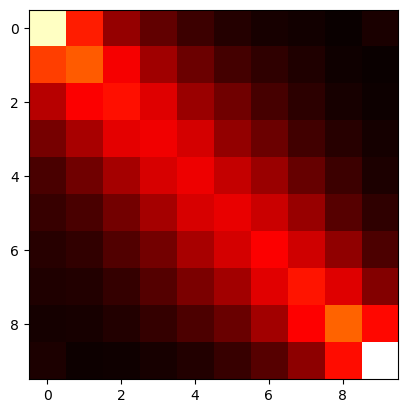

In [33]:
compute_transition_matrix(mom_quantiles_6mo, 'price_mom_6mo_quantile', 10, lag=1, plot=True)

array([[0.50007443, 0.19679452, 0.09822359, 0.06232323, 0.04205329,
        0.0289287 , 0.02399147, 0.01764005, 0.0143403 , 0.01563043],
       [0.21904813, 0.28577571, 0.18255355, 0.11037059, 0.06842063,
        0.04627664, 0.03283975, 0.02351455, 0.01768294, 0.01351751],
       [0.11040889, 0.19689994, 0.22697431, 0.17058487, 0.11212509,
        0.06971043, 0.04669155, 0.03056471, 0.02078509, 0.01525511],
       [0.06764921, 0.11340793, 0.18306196, 0.2096665 , 0.16236352,
        0.10200211, 0.06716155, 0.04554198, 0.03045163, 0.01869361],
       [0.04852682, 0.07197638, 0.11589605, 0.176258  , 0.20081108,
        0.14977378, 0.10384021, 0.06725888, 0.0411333 , 0.02452549],
       [0.0345511 , 0.05046591, 0.0781837 , 0.1181482 , 0.16683922,
        0.19985209, 0.15444461, 0.10285461, 0.0616181 , 0.03304245],
       [0.02705637, 0.03453684, 0.05311736, 0.08056586, 0.12041143,
        0.16550538, 0.21228848, 0.16031732, 0.09652219, 0.04967876],
       [0.02075346, 0.02718545, 0.0378315

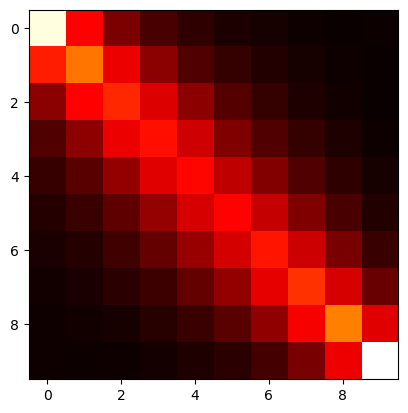

In [34]:
compute_transition_matrix(mom_quantiles_12mo, 'price_mom_12mo_quantile', 10, lag=1, plot=True)

## Value

We use **Excess Spread to Peers** as a Value Signal in our strategy.

In [35]:
bond_data.select('oas').null_count()

oas
u32
0


In [36]:
bond_data.filter(pl.col('oas').is_nan()).n_unique('cusip')

4835

In [37]:
oas_bucket_means = bond_data.group_by(['date', 'bucket']).agg(pl.col('oas').drop_nans().mean().alias('ESP_bucket_mean_oas'))

In [38]:
oas_bucket_means

date,bucket,ESP_bucket_mean_oas
date,str,f64
2009-02-28,"""2_A_1""",0.027662
2012-02-29,"""3_B_2""",0.030089
2003-09-30,"""4_B_2""",0.024077
2007-10-31,"""2_A_2""",0.009738
2005-11-30,"""3_A_2""",0.010698
…,…,…
2009-07-31,"""1_A_1""",0.012977
2010-04-30,"""5_A_1""",0.019134
2010-01-31,"""2_B_1""",0.045483


In [39]:
bond_data = bond_data.join(oas_bucket_means, on=['date', 'bucket'], how='left')

In [40]:
bond_data = bond_data.with_columns( 
    ESP = pl.col('oas') - pl.col('ESP_bucket_mean_oas'))

In [41]:
bond_data.select('de_ratio', 'intcov_ratio', 'debt_ebitda').null_count()

de_ratio,intcov_ratio,debt_ebitda
u32,u32,u32
106280,136290,109137


In [42]:
bond_data.head(3)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,RET_L5M,REMCOUPS,DURATION_right,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,spread_duration,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,ESP_bucket_mean_oas,ESP
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,i64,f64,str,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,null,10,4.72,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,"""2_A_2""",0.046874,0.044825,0.001213,1.045719,0.001269,0.004917,2.74186,null,NaN,NaN,NaN,NaN,0.011886,-0.001962
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,""".6186%""",10,4.65,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,"""2_A_2""",0.037299,0.044825,0.001213,0.832115,0.00101,0.010719,2.326775,0.005232,NaN,NaN,NaN,NaN,0.010394,-0.002364
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,"""1.173%""",10,4.57,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,"""2_A_2""",0.032447,0.044825,0.001213,0.72386,0.000878,-0.001969,2.368057,0.002861,NaN,NaN,NaN,NaN,0.009634,-0.00253


In [43]:
col = 'ESP'
bond_data.filter(pl.col(col).is_nan()).shape

(52635, 114)

In [44]:
bond_data_with_residuals = bond_data.with_columns(
    esp_residual = pl
        .col('ESP')
        .least_squares
        .ols(pl.col("debt_ebitda"), pl.col("intcov_ratio"), pl.col("de_ratio"), add_intercept=True, mode="residuals", null_policy='drop', solve_method='svd')
        .over(['date', 'bucket'])
)

In [45]:
bond_data_with_residuals.filter((pl.col('esp_residual').is_not_null()) & (pl.col('esp_residual').is_not_nan())).head(2)

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,REMCOUPS,DURATION_right,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,spread_duration,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,ESP_bucket_mean_oas,ESP,esp_residual
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,f64,str,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
127962,2004-07-31,"""001055AB8""",0.000873,-0.017158,-0.014029,0.001973,0.003867,0.002867,-0.002251,6.0,0.013455,0.212103,0.046817,450000.0,450000.0,107.586,1.07586,57.3,3.992089,16.0,6321,0.008182,0.028929,0.01842,3.0,1.0,1.0,0.045613,0.011889,108.1396,109.963208,19.55999,0.110292,4.84137e7,4.866282e7,6.5,…,10,3.99,null,null,null,null,57904,92,2002-07-02,2009-04-06,1449,0.165,1.079,6.223,58.174,null,-0.028669,null,null,0.000901,0.011131,"""4_A_1""",0.044436,0.024287,0.00117,1.829616,0.002141,-0.000168,0.906709,-0.000011,NaN,-0.057883,NaN,-0.022671,0.006789,0.004342,0.004508
430235,2009-11-30,"""001055AC6""",-0.013763,0.024369,0.022565,-0.013663,0.046749,0.046749,0.025176,7.0,0.034986,-0.341368,0.05989,850000.0,850000.0,117.957761,1.179578,115.1,6.703946,16.0,6321,0.016438,-0.022344,null,18.0,1.0,1.0,0.059052,0.032916,118.5923,118.946467,57.694375,-0.396697,1.00264097e8,1.00803455e8,8.5,…,19,6.7,null,null,null,null,57904,92,2009-05-18,2015-04-10,1449,0.213,0.861,10.884,41.296,null,0.116272,null,null,0.019599,0.029406,"""4_A_2""",0.197133,0.072579,0.001804,2.716117,0.004901,-0.018564,3.105562,-0.000992,0.055526,0.097936,NaN,NaN,0.024598,0.004807,0.0295


In [46]:
bond_data_with_residuals.filter((pl.col('esp_residual').is_not_null()) & (pl.col('esp_residual').is_not_nan())).shape

(11418, 115)

In [47]:
bond_data = bond_data_with_residuals

In [48]:
residuals_quantiles = compute_quantiles(bond_data, 'esp_residual', 5) 

computing... 2000/4437 ... done!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: b'There are other near singularities as well. 4.0804'

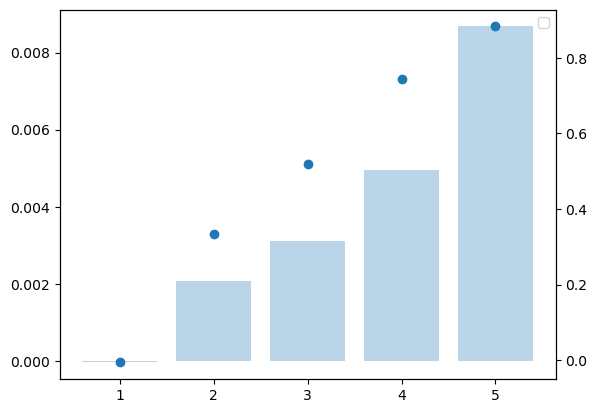

In [49]:
get_expected_alpha(residuals_quantiles, 'esp_residual_quantile', plot=True, interpolate=True)

## Quality

We use Interest Coverage Ratio as a Quality Signal in our strategy.

In [ ]:
intcov_quantiles = compute_quantiles(bond_data, 'debt_ebitda', 5) 

In [ ]:
get_expected_alpha(intcov_quantiles, 'debt_ebitda_quantile', plot=True, interpolate=True)

In [ ]:
intcov_quantiles

## Equity Momentum in Credit

In [ ]:
def equity_momentum(df: pl.DataFrame, period: str, min_periods: int, n_months: int):
    eq_momentum_returns = df.sort(['cusip', 'date']).rolling('date', group_by='cusip', period=period).agg(
        pl.when(pl.col('equity_month_return').len() > min_periods).then(pl.col('equity_month_return').add(1).product().sub(1)).otherwise(np.nan).alias(f'eq_mom_{n_months}mo'),
        )
    return eq_momentum_returns

eq_mom_6mo = equity_momentum(bond_data, '5mo20d', 5, 6)
eq_mom_12mo = equity_momentum(bond_data, '11mo20d', 9, 12)

bond_data = bond_data.join(
    eq_mom_6mo,
    how='left',
    on=['cusip', 'date'],
).join(
    eq_mom_12mo,
    how='left',
    on=['cusip', 'date'],
)

In [ ]:
bond_data.head(2)

In [ ]:
eq_mom_6mo_quantiles = compute_quantiles(bond_data, 'eq_mom_6mo', 10)
eq_mom_12mo_quantiles = compute_quantiles(bond_data, 'eq_mom_12mo', 10)

In [ ]:
get_expected_alpha(eq_mom_6mo_quantiles, 'eq_mom_6mo_quantile', plot=True, interpolate=True)

In [ ]:
get_expected_alpha(eq_mom_12mo_quantiles, 'eq_mom_12mo_quantile', plot=True, interpolate=True)

# Computing Partial Returns

# Hidden Markov Model

# Fama-Macbeth Regression

In [71]:
bond_data.head()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,REMCOUPS,DURATION_right,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE,PERMNO,PERMCO,link_startdt,link_enddt,gvkey,capital_ratio,debt_ebitda,de_ratio,intcov_ratio,cash_ratio,equity_month_return,datadate,shortintadj,unexpected_inflation,oas,bucket,dxs,weighted_dxs_median,weighted_ret_median,relative_dxs,systematic_return,residual_return_t+1,spread_duration,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,ESP_bucket_mean_oas,ESP,esp_residual
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,f64,str,str,str,str,i64,i64,date,date,i64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,10,4.72,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.129911,null,null,-0.004386,0.009923,"""2_A_2""",0.046874,0.044825,0.001213,1.045719,0.001269,0.004917,2.74186,null,NaN,NaN,NaN,NaN,0.011886,-0.001962,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,10,4.65,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.03226,null,null,0.007169,0.00803,"""2_A_2""",0.037299,0.044825,0.001213,0.832115,0.00101,0.010719,2.326775,0.005232,NaN,NaN,NaN,NaN,0.010394,-0.002364,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,10,4.57,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.063111,null,null,-0.007437,0.007105,"""2_A_2""",0.032447,0.044825,0.001213,0.72386,0.000878,-0.001969,2.368057,0.002861,NaN,NaN,NaN,NaN,0.009634,-0.00253,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,10,4.48,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,-0.001732,null,null,0.00195,0.007447,"""2_A_2""",0.033374,0.044825,0.001213,0.744546,0.000903,0.001382,2.347895,-0.000213,NaN,NaN,NaN,NaN,0.010046,-0.002599,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,10,4.4,null,null,null,null,88953,41444,2012-05-03,2017-05-02,null,null,null,null,null,null,0.079677,null,null,-0.002976,0.006749,"""2_A_2""",0.0297,0.044825,0.001213,0.662582,0.000804,0.00118,2.129103,0.002107,NaN,NaN,NaN,NaN,0.008798,-0.002049,null


In [76]:
oas_quantiles.select('residual_return_t+1', 'oas_bucket_delta', 'cusip').with_columns(
    pl.col('residual_return_t+1').least_squares.ols(pl.col('oas_bucket_delta'), add_intercept=True, mode="coefficients", null_policy='drop', solve_method='svd').over('cusip')
).head()

residual_return_t+1,oas_bucket_delta,cusip,coefficients
f64,f64,str,struct[2]
0.029829,-0.002715,"""00077QAG5""","{1.760983,0.004038}"
-0.040187,0.123368,"""00104CAA6""","{0.187088,0.003812}"
0.003573,0.00012,"""001055AB8""","{2.11055,0.000407}"
-0.105981,0.054246,"""00130HAQ8""","{0.877668,-0.00231}"
-0.030024,0.114988,"""00130HAU9""","{0.163636,0.003937}"


In [81]:
coefficients = oas_quantiles.select('date', 'cusip', pl.col('residual_return_t+1').least_squares.ols(pl.col('oas_bucket_delta'), add_intercept=True, mode='coefficients', null_policy='drop', solve_method='svd').over('cusip')).unnest('coefficients')

coefficients.head()

date,cusip,oas_bucket_delta,const
date,str,f64,f64
2002-08-31,"""00077QAG5""",1.760983,0.004038
2002-08-31,"""00104CAA6""",0.187088,0.003812
2002-08-31,"""001055AB8""",2.11055,0.000407
2002-08-31,"""00130HAQ8""",0.877668,-0.00231
2002-08-31,"""00130HAU9""",0.163636,0.003937


In [84]:
coefficients.filter(pl.col('cusip') == "00077QAG5").select('oas_bucket_delta')

oas_bucket_delta
f64
1.760983


In [ ]:
oas_quantiles.head()

In [ ]:
regression_data = oas_quantiles.select('date', 'cusip', 'exretnc_t+1', 'oas_quantile')
mkt_returns = regression_data.group_by('date').agg(pl.col('exretnc_t+1').mean().alias('mkt_return'))
regression_data = regression_data.join(
    mkt_returns,
    how='left',
    on='date'
)

regression_data.head()

In [ ]:
datevar = 'date'
yvar = 'exretnc_t+1'
xvar = ['oas_quantile', 'mkt_return']

all_cols = [datevar, yvar, *xvar]
regression_data_pandas = regression_data.select(all_cols).to_pandas().dropna()

regression_data_pandas.head()

In [ ]:
regression_data_pandas.dtypes

In [ ]:
regression_data_pandas.isna().sum()

In [ ]:
fm_regression_results = fama_macbeth.fama_macbeth(regression_data_pandas, t=datevar, yvar=yvar, xvar=xvar)
fama_macbeth.fm_summary(fm_regression_results, pvalues=True)

In [ ]:
fm_regression_results

In [ ]:
fm_regression_results.rolling(12).mean().plot(y='oas_quantile')